Preprocessing

In [13]:
import pandas as pd

df = pd.read_csv('DataSet/training/train_lyrics_1000.csv')

df.head()

,file,artist,title,lyrics,genre,mood,year
0,TRAAAAW128F429D538.h5,Casual,I Didn't Mean To,Verse One:\n\nAlright I might\nHave had a litt...,Hip Hop/Rap,sad,1994
1,TRAAAEF128F4273421.h5,Adam Ant,Something Girls,Adam Ant/Marco Pirroni\nEvery girl is a someth...,Rock,happy,1982
2,TRAAAFD128F92F423A.h5,Gob,Face the Ashes,"I've just erased it's been a while, I've got a...",Rock,sad,2007
3,TRAABJV128F1460C49.h5,Lionel Richie,Tonight Will Be Alright,Little darling \nWhere you've been so long \nI...,R&B,happy,1986
4,TRAABLR128F423B7E3.h5,Blue Rodeo,Floating,"Lead Vocal by Greg\n\nWell, these late night c...",Rock,sad,1987


In [14]:
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np

X_train = df['lyrics'].values 

y_train = df['mood'].values

print('before: %s ...' %y_train[:5])

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train[:5])

before: ['sad' 'happy' 'sad' 'happy' 'sad'] ...
after: [1 0 1 0 1] ...


In [5]:
import pickle

pickle_out = open('./lyrics_label_encoder_py.pkl', 'wb')
pickle.dump(le, pickle_out)
pickle_out.close()

Feature Extraction

In [2]:
import nltk
import string
import re

porter_stemmer = nltk.stem.porter.PorterStemmer()

def porter_tokenizer(text, stemmer=porter_stemmer):
    """
    A Porter-Stemmer-Tokenizer hybrid to splits sentences into words (tokens) 
    and applies the porter stemming algorithm to each of the obtained token. 
    Tokens that are only consisting of punctuation characters are removed as well.
    Only tokens that consist of more than one letter are being kept.
    
    Parameters
    ----------
        
    text : `str`. 
      A sentence that is to split into words.
        
    Returns
    ----------
    
    no_punct : `str`. 
      A list of tokens after stemming and removing Sentence punctuation patterns.
    
    """
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [porter_stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return no_punct

Test Example for Tokenizer

In [3]:
porter_tokenizer("Don't !!! --- want swimming. ")

['don', 't', 'want', 'swim']

In [7]:
with open('./stopwords_eng.txt', 'r') as infile:
    stop_words = infile.read().splitlines()
print('stop words %s ...' %stop_words[:5])

stop words ['i', 'me', 'my', 'myself', 'we'] ...


Count Vectorizer

In [8]:

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer,
            ngram_range=(1,1)
    )

Test #1

In [9]:
vocab = ["123 1 The\n swimmer likes swimming so he swims. Don't didn`t"]

vec = vec.fit(vocab)

sentence1 = vec.transform([u'The swimmer likes swimming.'])
sentence2 = vec.transform(['The\nswimmer \nswims.'])


print('TEST:')
print('Vocabulary: %s' %vec.get_feature_names())
print('Sentence 1: %s' %sentence1.toarray())
print('Sentence 2: %s' %sentence2.toarray())

TEST:
Vocabulary: ['didn', 'like', 'swim', 'swimmer']
Sentence 1: [[0 1 1 1]]
Sentence 2: [[0 0 1 1]]


Fitting the lyrics

In [16]:
vec = vec.fit(X_train.ravel())
print('Vocabulary size: %s' %len(vec.get_feature_names()))

Vocabulary size: 8550


Test #2 for N-grams = 2

In [17]:
vec = CountVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer,
            ngram_range=(2,2)
    )

vocab = ["123 1 The\n swimmer likes swimming so he swims. Don't didn`t"]

vec = vec.fit(vocab)

sentence1 = vec.transform([u'The swimmer likes swimming.'])
sentence2 = vec.transform(['The\nswimmer \nswims.'])


print('TEST:')
print('Vocabulary: %s' %vec.get_feature_names())
print('Sentence 1: %s' %sentence1.toarray())
print('Sentence 2: %s' %sentence2.toarray())

TEST:
Vocabulary: ['like swim', 'swim didn', 'swim swim', 'swimmer like']
Sentence 1: [[1 0 0 1]]
Sentence 2: [[0 0 0 0]]


Tfidf Vectorizer

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer
    )

Test for Tfidf Vectorizer

In [19]:
vocab = ["123 1 I like Batman and Superman but not Marvel comics. Don't didn`t"]

tfidf = tfidf.fit(vocab)

sentence1 = tfidf.transform([u'I like Batman and Superman but not Marvel comics.'])
sentence2 = tfidf.transform(['I \nlike Batman and \nSuperman but not \nMarvel comics.'])


print('TEST:')
print('Vocabulary: %s' %tfidf.get_feature_names())
print('Sentence 1: %s' %sentence1.toarray())
print('Sentence 2: %s' %sentence2.toarray())

TEST:
Vocabulary: ['batman', 'comic', 'didn', 'like', 'marvel', 'superman']
Sentence 1: [[ 0.4472136  0.4472136  0.         0.4472136  0.4472136  0.4472136]]
Sentence 2: [[ 0.4472136  0.4472136  0.         0.4472136  0.4472136  0.4472136]]


Fitting the lyrics 

In [20]:
tfidf = tfidf.fit(X_train.ravel())

print('Vocabulary size: %s' %len(tfidf.get_feature_names()))

Vocabulary size: 8550


In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

In [22]:
from sklearn import metrics

# `pos_label` for positive class, since we have sad=1, happy=0

f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label=0)

Grid Search

In [24]:
from sklearn.grid_search import GridSearchCV
from pprint import pprint

pipeline_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', BernoulliNB())
])

parameters_1 = dict(
    vect__binary=[True],
    vect__stop_words=[stop_words, None],
    vect__tokenizer=[porter_tokenizer, None],
    vect__ngram_range=[(1,1), (2,2), (3,3)],
)

grid_search_1 = GridSearchCV(pipeline_1, 
                           parameters_1, 
                           n_jobs=1, 
                           verbose=1,
                           scoring=f1_scorer,
                           cv=10
                        )

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_1.steps])
print("parameters:")
pprint(parameters_1, depth=2)
grid_search_1.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search_1.best_score_)
print("Best parameters set:")
best_parameters_1 = grid_search_1.best_estimator_.get_params()
for param_name in sorted(parameters_1.keys()):
    print("\t%s: %r" % (param_name, best_parameters_1[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': [True],
 'vect__ngram_range': [(...), (...), (...)],
 'vect__stop_words': [[...], None],
 'vect__tokenizer': [<function porter_tokenizer at 0x00000270ECDE6E18>, None]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


C:\Users\upste\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\upste\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\upste\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\upste\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\upste\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

Best score: 0.617
Best parameters set:
	vect__binary: True
	vect__ngram_range: (1, 1)
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 

In [25]:
from sklearn.grid_search import GridSearchCV

pipeline_3 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

parameters_3 = dict(
    vect__binary=[False],
    vect__stop_words=[stop_words, None],
    vect__tokenizer=[porter_tokenizer, None],
    vect__ngram_range=[(1,1), (2,2), (3,3)],
)

grid_search_3 = GridSearchCV(pipeline_3, 
                           parameters_3, 
                           n_jobs=1, 
                           verbose=1,
                           scoring=f1_scorer,
                           cv=10
                )


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_3.steps])
print("parameters:")
pprint(parameters_3, depth=2)
grid_search_3.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search_3.best_score_)
print("Best parameters set:")
best_parameters_3 = grid_search_3.best_estimator_.get_params()
for param_name in sorted(parameters_3.keys()):
    print("\t%s: %r" % (param_name, best_parameters_3[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': [False],
 'vect__ngram_range': [(...), (...), (...)],
 'vect__stop_words': [[...], None],
 'vect__tokenizer': [<function porter_tokenizer at 0x00000270ECDE6E18>, None]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.4min finished


Best score: 0.620
Best parameters set:
	vect__binary: False
	vect__ngram_range: (1, 1)
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',

GRID SEARCH USING ROC CURVES

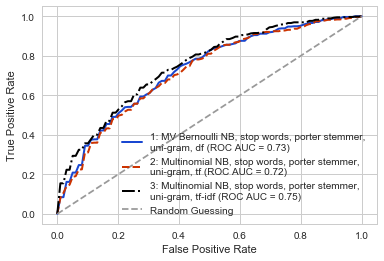

In [27]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")

clf_1 = Pipeline([
                  ('vect', CountVectorizer(
                                           binary=True,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', BernoulliNB()),
                 ])

clf_2 = Pipeline([
                  ('vect', CountVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', MultinomialNB()),
                 ])

clf_3 = Pipeline([
                  ('vect', TfidfVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', MultinomialNB()),
                 ])

colors = ['#1947D1', '#CC3300', 'k']
linestyles = ['-', '--', '-.']
classifiers = [clf_1, clf_2, clf_3]
labels = ['1: MV Bernoulli NB, stop words, porter stemmer, \nuni-gram, df', 
          '2: Multinomial NB, stop words, porter stemmer, \nuni-gram, tf',
          '3: Multinomial NB, stop words, porter stemmer, \nuni-gram, tf-idf',
          ]

for clf,col,ls,lab in zip(classifiers, colors, linestyles, labels):
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    cv = StratifiedKFold(y_train, n_folds=10, random_state=123)

    for i, (train, test) in enumerate(cv):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('./images/roc_gridsearch_1.eps', dpi=300)
plt.show()

Hyperparameter tuning 1 - max_features

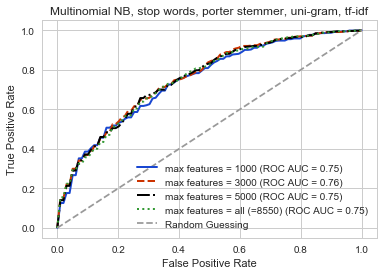

In [28]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")


colors = ['#1947D1', '#CC3300', 'k', '#339933']
linestyles = ['-', '--', '-.', ':']
params = [1000,3000,5000,None]
labels = ['max features = 1000', 
          'max features = 3000',
          'max features = 5000',
          'max features = all (=8550)',
          ]

for param,col,ls,lab in zip(params, colors, linestyles, labels):

    clf = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=porter_tokenizer,
                                                  ngram_range=(1,1),
                                                  max_features=param,
                                                  )
                          ),
                         ('clf', MultinomialNB()),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    cv = StratifiedKFold(y_train, n_folds=10, random_state=123)

    for i, (train, test) in enumerate(cv):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multinomial NB, stop words, porter stemmer, uni-gram, tf-idf')
plt.legend(loc="lower right")
plt.savefig('./images/roc_maxfeatures.eps', dpi=300)
plt.show()

Hyperparameter tuning 3 - alpha

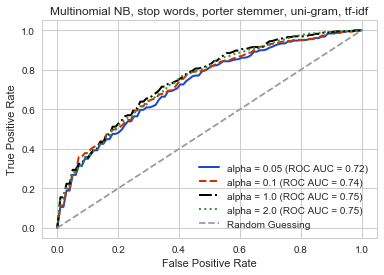

In [29]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")


colors = ['#1947D1', '#CC3300', 'k', '#339933']
linestyles = ['-', '--', '-.', ':']
params = [0.05, 0.1, 1.0, 2.0]
labels = ['alpha = 0.05', 
          'alpha = 0.1',
          'alpha = 1.0',
          'alpha = 2.0',
          ]

for param,col,ls,lab in zip(params, colors, linestyles, labels):

    clf = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=porter_tokenizer,
                                                  ngram_range=(1,1),
                                                  
                                                  )
                          ),
                         ('clf', MultinomialNB(alpha=param)),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    cv = StratifiedKFold(y_train, n_folds=10, random_state=123)

    for i, (train, test) in enumerate(cv):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Multinomial NB, stop words, porter stemmer, uni-gram, tf-idf')
plt.savefig('./images/roc_alpha.eps', dpi=300)
plt.show()


n-gram comparison


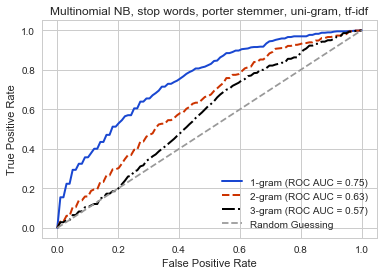

In [30]:


from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")


colors = ['#1947D1', '#CC3300', 'k', ]
linestyles = ['-', '--', '-.',]
params = [(1,1), (2,2), (3,3),]
labels = ['1-gram', 
          '2-gram',
          '3-gram',
          ]

for param,col,ls,lab in zip(params, colors, linestyles, labels):

    clf = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=porter_tokenizer,
                                                  ngram_range=param,
                                                  
                                                  )
                          ),
                         ('clf', MultinomialNB(alpha=1.0)),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    cv = StratifiedKFold(y_train, n_folds=10, random_state=123)

    for i, (train, test) in enumerate(cv):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Multinomial NB, stop words, porter stemmer, uni-gram, tf-idf')
plt.savefig('./images/roc_ngrams.eps', dpi=300)
plt.show()



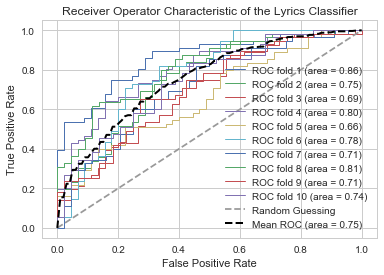

In [31]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")

classifier = Pipeline([
               ('vect', TfidfVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', MultinomialNB()),
              ])


cv = StratifiedKFold(y_train, n_folds=10, random_state=123)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic of the Lyrics Classifier')
plt.legend(loc="lower right")
plt.savefig('./images/roc_final.eps', dpi=300)
plt.show()

Validation

In [32]:
final_clf = Pipeline([
                ('vect', TfidfVectorizer(
                                         binary=False,
                                         stop_words=stop_words,
                                         tokenizer=porter_tokenizer,
                                         ngram_range=(1,1),
                                         )
                ),
                ('clf', MultinomialNB(alpha=1.0)),
               ])
final_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...se_idf=True, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Confusion Matrix

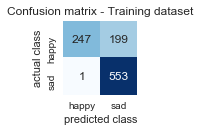

In [33]:
import matplotlib as mpl
import numpy as np

cm = metrics.confusion_matrix(y_train, final_clf.predict(X_train))

np.set_printoptions(suppress=True)
mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Training dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
plt.savefig('./images/confmat_training.eps', dpi=300)
plt.show()

In [38]:
df = pd.read_csv('DataSet/validation/valid_lyrics_200.csv')

X_valid = df['lyrics'].values 
y_valid = df['mood'].values

y_valid = le.transform(y_valid)

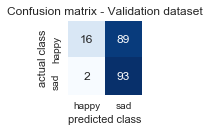

In [39]:
cm = metrics.confusion_matrix(y_valid, final_clf.predict(X_valid))

np.set_printoptions(suppress=True)
mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Validation dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
plt.savefig('./images/confmat_valid.eps', dpi=300)
plt.show()


ROC AUC, Accuracy, Precision, Recall, and F1-score


In [40]:
from sklearn import metrics

# `pos_label` for positive class, since we have sad=1, happy=0

acc_scorer = metrics.make_scorer(metrics.accuracy_score, greater_is_better=True)
pre_scorer = metrics.make_scorer(metrics.precision_score, greater_is_better=True, pos_label=0)
rec_scorer = metrics.make_scorer(metrics.recall_score, greater_is_better=True, pos_label=0)
f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label=0)
auc_scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True)

In [41]:
d = {'Data':['Training', 'Validation'],
     'ACC (%)':[],
     'PRE (%)':[],
     'REC (%)':[],
     'F1 (%)':[],
     'ROC AUC (%)':[],
}

d['ACC (%)'].append(acc_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['PRE (%)'].append(pre_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['REC (%)'].append(rec_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['F1 (%)'].append(f1_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['ROC AUC (%)'].append(auc_scorer(estimator=final_clf, X=X_train, y_true=y_train))

d['ACC (%)'].append(acc_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['PRE (%)'].append(pre_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['REC (%)'].append(rec_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['F1 (%)'].append(f1_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['ROC AUC (%)'].append(auc_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))

df_perform = pd.DataFrame(d)
df_perform = df_perform[['ACC (%)', 'PRE (%)', 'REC (%)', 'F1 (%)', 'ROC AUC (%)']]
df_perform.index=(['Training', 'Validation'])
df_perform = df_perform*100
df_perform = np.round(df_perform, decimals=2)
df_perform

,ACC (%),PRE (%),REC (%),F1 (%),ROC AUC (%)
Training,80.0,99.60,55.38,71.18,77.60
Validation,54.5,88.89,15.24,26.02,56.57


In [44]:
df_perform.to_csv('./classifier_performance.csv', index_label=False)

Saving the Classifier

In [43]:
lyrics_clf_1000 = final_clf

pickle_out = open('./lyrics_clf_1000_py27.pkl', 'wb')
pickle.dump(lyrics_clf_1000, pickle_out)
pickle_out.close()